In [ ]:
!pip install shapely
!pip install contextily
import networkx as nx
import numpy as np
import pandas as pd
import geopandas as gpd
import json
import re
import os
import urllib
from matplotlib import pyplot as plt  #to avoid the warning message by plotting the geometries
import warnings

warnings.simplefilter("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 33.5 MB/s eta 0:00:00


In [ ]:
R04_indicator_seziono = pd.read_csv("/content/drive/MyDrive/NEU_LONDON/R04_indicatori_2011_sezioni.csv", delimiter=';', encoding='ISO-8859-1')
R04_shapefile_seziono = gpd.read_file("/content/drive/MyDrive/NEU_LONDON/R04_11_WGS84/R04_11_WGS84.shp")
Trentino_grid = gpd.read_file("/content/drive/MyDrive/NEU_LONDON/trentino-grid.geojson")

## 1 Data manipulation

### 1.1 Trentino **section (sezioni) scale** Census data manipulation : shapefile and indicators

In [ ]:
# crs check and reproject to EPSG:32632
print(R04_shapefile_seziono.crs)
print(Trentino_grid.crs)
Trentino_grid = Trentino_grid.to_crs('epsg:32632')

EPSG:32632
EPSG:4326


In [ ]:
R04_indicator_seziono.head(2)

,CODREG,REGIONE,CODPRO,PROVINCIA,CODCOM,COMUNE,PROCOM,SEZ2011,NSEZ,ACE,...,E22,E23,E24,E25,E26,E27,E28,E29,E30,E31
0,4,Trentino-Alto Adige/Südtirol,21,Bolzano/Bozen,1,Aldino/Aldein,21001,210010000001,1,0,...,1,0,1,0,0,20,6,8,1,0
1,4,Trentino-Alto Adige/Südtirol,21,Bolzano/Bozen,1,Aldino/Aldein,21001,210010000002,2,0,...,7,4,2,0,0,49,11,8,4,0


In [ ]:
R04_shapefile_seziono.head(2)

,COD_REG,COD_ISTAT,PRO_COM,SEZ2011,SEZ,COD_STAGNO,COD_FIUME,COD_LAGO,COD_LAGUNA,COD_VAL_P,...,COD_MONT_D,LOC2011,COD_LOC,TIPO_LOC,COM_ASC,COD_ASC,ACE,Shape_Leng,Shape_Area,geometry
0,4.0,4022006.0,22006.0,220060000040,40.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.200610e+09,10001.0,1.0,0.0,0,0,1236.098493,39288.700138,"POLYGON ((644727.314 5087220.073, 644710.966 5..."
1,4.0,4022006.0,22006.0,220060000068,68.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.200610e+09,10001.0,1.0,0.0,0,0,817.121900,18964.885179,"POLYGON ((644375.285 5086668.016, 644185.720 5..."


- Official census data of R04 includes Bolzano/Bozen and Trentino
- Filtering out Trentino (PRO == 22)

In [ ]:
Trentino_indicator_seziono = R04_indicator_seziono[R04_indicator_seziono['CODPRO']==22] #5117 rows × 152 columns

R04_shapefile_seziono['PRO_COM'] = R04_shapefile_seziono['PRO_COM'].astype(str)
Trentino_shapefile_seziono = R04_shapefile_seziono[R04_shapefile_seziono['PRO_COM'].str.startswith('22')] #6081 rows × 25 columns

Checking the plot with grid

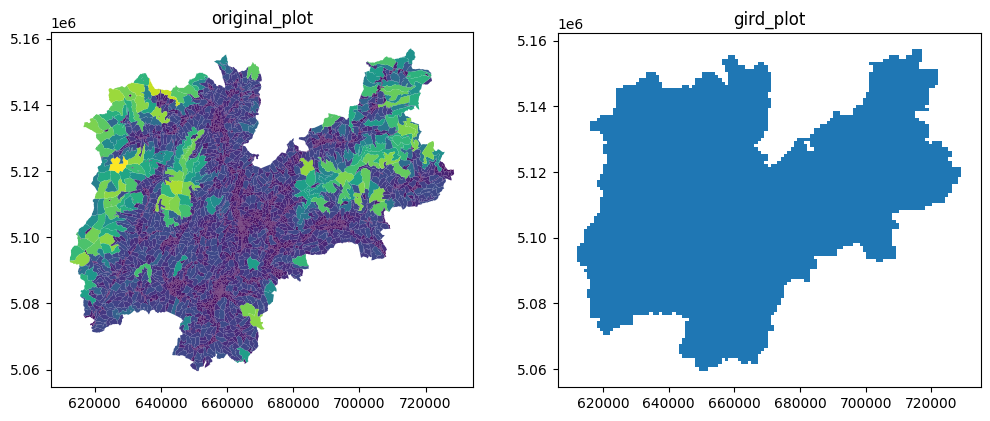

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

Trentino_shapefile_seziono.plot(column='Shape_Area',ax=ax[0])
ax[0].set_title('original_plot')

Trentino_grid.plot(ax=ax[1])
ax[1].set_title('gird_plot')

plt.show()
#R04_shapefile.plot(column='Shape_Area', legend=True)

- SEZ2011 is the unique identifier encoded in a census block, which is the finest code
- Checking result indicates that indicator file has 964 missing rows

In [ ]:
duplicates = Trentino_indicator_seziono[Trentino_indicator_seziono['SEZ2011'].isin(Trentino_shapefile_seziono['SEZ2011'])]
#duplicate:5117 rows - the same as Trentino_indicator_seziono
missing_in_shapefile = Trentino_indicator_seziono[~Trentino_indicator_seziono['SEZ2011'].isin(Trentino_shapefile_seziono['SEZ2011'])]
# 0 rows
missing_in_indicator = Trentino_shapefile_seziono[~Trentino_shapefile_seziono['SEZ2011'].isin(Trentino_indicator_seziono['SEZ2011'])]
# 964 rows

Merging shapefile and census data

In [ ]:
Trentino_merged = Trentino_shapefile_seziono.merge(Trentino_indicator_seziono, on='SEZ2011', how='left')

### 1.2 Aggregating census data into grids

Calculating intersection area

In [ ]:
intersection = gpd.overlay(Trentino_merged, Trentino_grid, how='intersection')
intersection['area_ratio'] = intersection['geometry'].area / intersection['Shape_Area']
#intersection

In [ ]:
intersection_copy = intersection.iloc[:, 35:179].copy()

start_col_index = 0
end_col_index = 140

#intersection_copy.iloc[:, start_col_index:end_col_index] *= intersection_copy['area_ratio']
intersection_copy.iloc[:, start_col_index:end_col_index] = intersection_copy.iloc[:, start_col_index:end_col_index].multiply(intersection_copy['area_ratio'], axis=0)

In [ ]:
start_col_index = 0
end_col_index = 139

grouped_data = pd.pivot_table(intersection_copy, index='cellId', values=intersection_copy.columns[start_col_index:end_col_index], aggfunc='sum', dropna=True).reset_index()

In [ ]:
Trentino_grid_aggregation = Trentino_grid.merge(grouped_data, on='cellId', how='left')
Trentino_grid_aggregation.loc[(Trentino_grid_aggregation.iloc[:, 2:] == 0).all(axis=1), Trentino_grid_aggregation.columns[2:]] = pd.NA

In [ ]:
for cellId in Trentino_grid['cellId'].unique():
    grid_data = intersection[intersection['cellId'] == cellId]
grid_data

,COD_REG,COD_ISTAT,PRO_COM,SEZ2011,SEZ,COD_STAGNO,COD_FIUME,COD_LAGO,COD_LAGUNA,COD_VAL_P,...,E25,E26,E27,E28,E29,E30,E31,cellId,geometry,area_ratio
23333,4.0,4022039.0,22039.0,220390000015,15.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11454,"POLYGON ((716113.057 5156557.148, 716138.452 5...",0.00035


Check if it is the same

In [ ]:
#total_sum_P1 = Trentino_merged['P1'].sum()
#print(total_sum_P1)

524832.0


In [ ]:
#total_sum_P1 = Trentino_grid_aggregation['P1'].sum()
#print(total_sum_P1)

524823.320441058


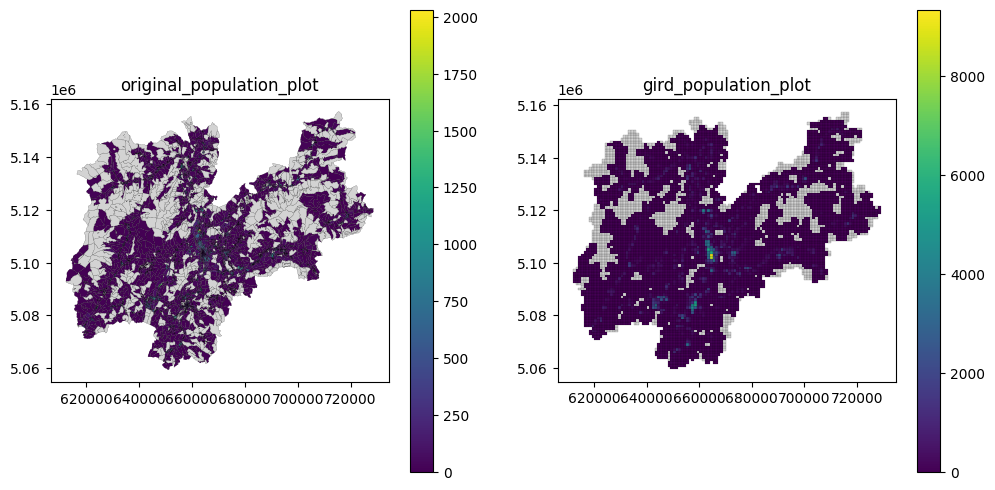

In [ ]:
# check the plot with grid
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

#Trentino_shapefile_seziono.plot(column='Shape_Area',ax=ax[0])
Trentino_merged.plot(column='P1',legend=True,edgecolor='black',cmap='viridis', linewidth=0.1,missing_kwds={'color': 'lightgrey'},ax=ax[0])
ax[0].set_title('original_population_plot')

#Trentino_grid.plot(ax=ax[1])
Trentino_grid_aggregation.plot(column='P1',legend=True,edgecolor='black', cmap='viridis', linewidth=0.1,missing_kwds={'color': 'lightgrey'},ax=ax[1])
ax[1].set_title('gird_population_plot')

plt.show()
#R04_shapefile.plot(column='Shape_Area', legend=True)

## 2 Census data

### 2.1 PCA

In [ ]:
Trentino_grid_aggregation_isnull = Trentino_grid_aggregation.dropna()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
grid_ids = Trentino_grid_aggregation_isnull['cellId']
geometry = Trentino_grid_aggregation_isnull['geometry']

X = Trentino_grid_aggregation_isnull.drop(['cellId', 'geometry'], axis=1)

# Data standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [ ]:
eigenvalues = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

pca_results_df = pd.DataFrame({
    'Eigenvalues': eigenvalues,
    'Proportion of Variance': explained_variance_ratio,
    'Cumulative Variance': cumulative_variance_ratio
})

pca_results_df.head(10)

,Eigenvalues,Proportion of Variance,Cumulative Variance
0,113.864671,0.819015,0.819015
1,7.983787,0.057426,0.876441
2,2.413409,0.017359,0.893801
3,1.681157,0.012092,0.905893
4,1.252484,0.009009,0.914902
5,1.093154,0.007863,0.922765
6,0.999768,0.007191,0.929956
7,0.849607,0.006111,0.936067
8,0.754551,0.005427,0.941495
9,0.688852,0.004955,0.946449


TOP 6 components are choosed
- Using the Kaiser criterion, use only the principal components with eigenvalues that are greater than 1
- at least 90% of the variance explained

In [ ]:
# Top 6 components
pca_df = pd.DataFrame(X_pca[:, :6], columns=[f'PC{i}' for i in range(6)])
pca_df['cellId'] = grid_ids.values  # Ensure data alignment
pca_df['geometry'] = geometry.values
#pca_df

In [ ]:
loadings = pca.components_[:6]
# generating load matrices
loadings_df = pd.DataFrame(loadings, columns=X.columns, index=[f'PC{i}' for i in range(0, 6)])
sorted_abs_loadings = {}
for pc in loadings_df.index:
    sorted_abs_loadings[pc] = loadings_df.loc[pc].abs().sort_values(ascending=False).head(10).index

# replacing by original loading value (retain negative value)
top_loadings_original = {}
for pc in sorted_abs_loadings:
    top_loadings_original[pc] = loadings_df.loc[pc, sorted_abs_loadings[pc]]

top_loadings_original_df = pd.DataFrame(top_loadings_original)
top_loadings_original_df

,PC0,PC1,PC2,PC3,PC4,PC5
A3,NaN,NaN,0.309446,0.267454,0.325137,NaN
A6,NaN,NaN,0.306707,0.268593,0.328606,NaN
A7,NaN,NaN,0.238996,NaN,NaN,NaN
E10,NaN,NaN,NaN,NaN,NaN,-0.106160
E12,NaN,NaN,NaN,NaN,0.190433,NaN
E13,NaN,NaN,NaN,NaN,NaN,0.113868
E14,NaN,-0.172891,NaN,NaN,NaN,NaN
E15,NaN,NaN,NaN,NaN,0.178717,NaN
E16,NaN,NaN,NaN,NaN,0.195295,NaN
E17,NaN,-0.176729,NaN,NaN,-0.189347,-0.093347


Interpreting components
According to indicator description (https://github.com/ucfnlih/Trentino_Analysis/blob/main/tracciato_2011_sezioni.csv) </br>
The explanation of the components is as follows:

- **PC1: Population density and activity indicators.**</br>A larger PC1 value may mean that the community has a larger population size and higher population density
- **PC2: Refreshment level of housing and construction.**</br>A larger PC2 value may indicate the newer the housing and construction (negative relationship)
- **PC3: Housing diversity and level of education.** </br>Larger PC3 values may indicate that the region has a diversity of housing types and a higher proportion of highly educated residents
- **PC4: Characteristics of the foreign population.**</br> A larger PC4 value may indicate that the neighbourhood has a higher proportion of expatriate residents, reflecting higher cultural and nationality diversity
- **PC5: Building quality and maintenance status.** </br>A large PC5 value may mean that the buildings in the neighbourhood are of high overall quality and well-maintained
- **PC6: Elderly population and special populations (e.g. illiterate).**</br> A large PC6 value may indicate that the area has a high proportion of older people and groups requiring special attention




In [ ]:
rename_dict = {
    'PC0': 'PopDens_Activity',
    'PC1': 'HousingRefresh_Level',
    'PC2': 'HousingDiv_EduLevel',
    'PC3': 'ForeignPop_Char',
    'PC4': 'BldgQual_Maint',
    'PC5': 'Elderly_SpecialPop'
}

pca_df = pca_df.rename(columns=rename_dict)

### 2.2 Census data K-means

Deciding number of clusters

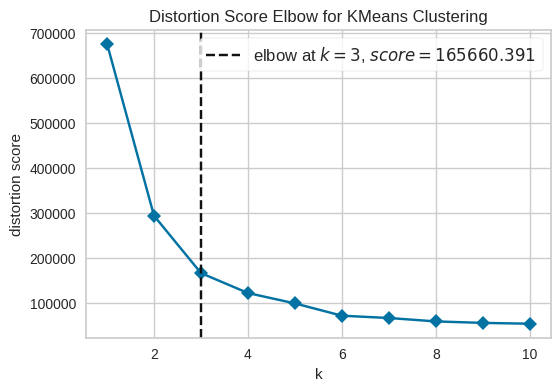

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
X_cluster = pca_df.drop(['cellId','geometry'], axis=1)
fig, ax = plt.subplots(figsize=(6, 4))

# Plotting Elbow chart on the first subplot
model = KMeans(init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
visualizer = KElbowVisualizer(model, k=(1, 11), timings=False, ax=ax)
visualizer.fit(X_cluster)
visualizer.finalize()

In [ ]:
kmeans = KMeans(n_clusters=3, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
kmeans.fit(X_cluster)

pca_df['Cluster'] = kmeans.labels_
gdf = gpd.GeoDataFrame(pca_df, geometry='geometry')
gdf.head(2)

,PopDens_Activity,HousingRefresh_Level,HousingDiv_EduLevel,ForeignPop_Char,BldgQual_Maint,Elderly_SpecialPop,cellId,geometry,Cluster
0,-2.871190,0.902244,-0.037617,-0.070177,0.060870,0.051353,38,"POLYGON ((649100.000 5060500.000, 650100.000 5...",1
1,-2.844789,0.884712,-0.035299,-0.067012,0.059963,0.051362,39,"POLYGON ((650100.000 5060500.000, 651100.000 5...",1


In [ ]:
cluster_name_map = {0: 'High', 1: 'Low', 2: 'Medium'}
gdf['Cluster_name'] = gdf['Cluster'].map(cluster_name_map)

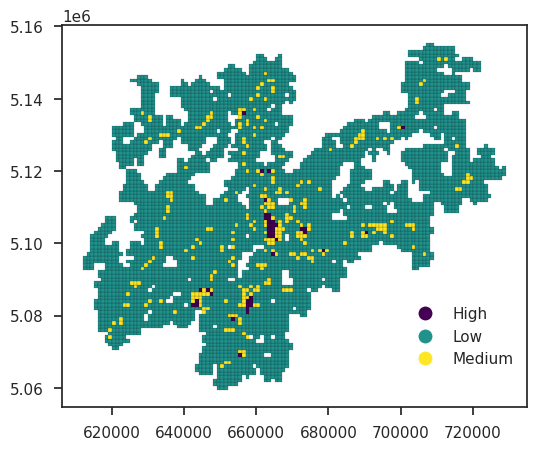

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
gdf.plot(column='Cluster_name', categorical=True, legend=True, cmap='viridis',
         edgecolor='black', linewidth=0.1, missing_kwds={'color': 'lightgrey'}, ax=ax)

leg = ax.get_legend()
leg.set_bbox_to_anchor((1, 0.3))

plt.show()

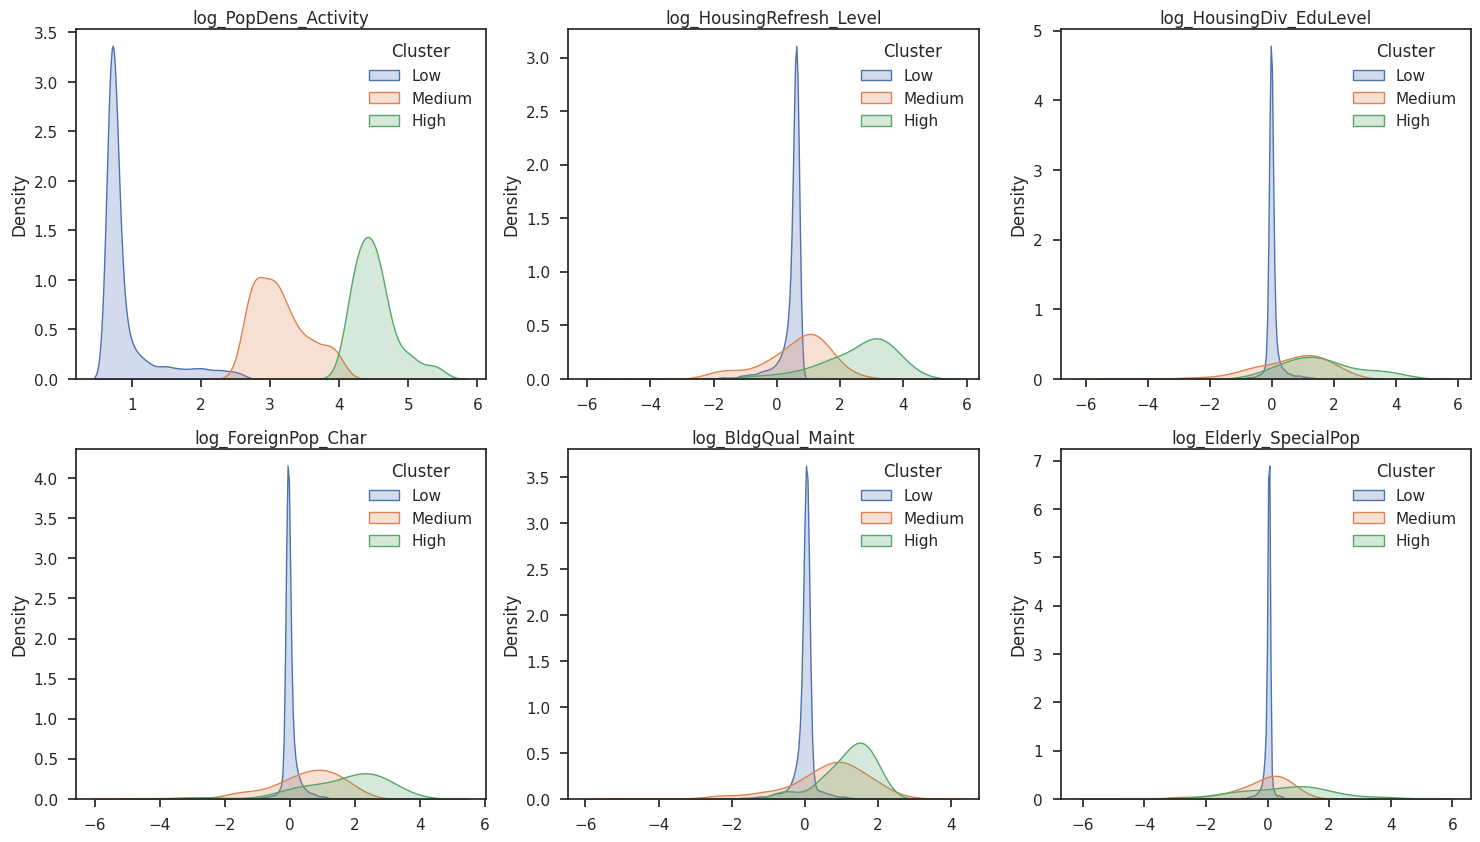

In [ ]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)


#gdf['log_PopDens_Activity'] = np.log1p(gdf['PopDens_Activity'])
gdf['log_PopDens_Activity'] = np.log1p(gdf['PopDens_Activity'] - gdf['PopDens_Activity'].min() + 1)
gdf['log_HousingRefresh_Level'] = np.log1p(gdf['HousingRefresh_Level'])
gdf['log_HousingDiv_EduLevel'] = np.log1p(gdf['HousingDiv_EduLevel'])
gdf['log_ForeignPop_Char'] = np.log1p(gdf['ForeignPop_Char'])
gdf['log_BldgQual_Maint'] = np.log1p(gdf['BldgQual_Maint'])
gdf['log_Elderly_SpecialPop'] = np.log1p(gdf['Elderly_SpecialPop'])


data_columns = gdf.columns.tolist()
columns_to_remove = ['Cluster_name','PopDens_Activity','HousingRefresh_Level','HousingDiv_EduLevel','ForeignPop_Char','BldgQual_Maint','Elderly_SpecialPop','geometry','Cluster',"cellId"]
for col in columns_to_remove:
    data_columns.remove(col)

# Setting numbers of column and row
num_cols = 3
num_rows = len(data_columns) // num_cols + (1 if len(data_columns) % num_cols > 0 else 0)

# Creating the subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18, 5 * num_rows))
axes = axes.flatten()

# Looping through each variable and plot the distributions for each cluster
for i, col in enumerate(data_columns):
    for cluster in gdf['Cluster_name'].unique():
        subset = gdf[gdf['Cluster_name']==cluster][col]
        sns.distplot(subset, hist=False, kde=True, kde_kws={'shade': True}, label=cluster, ax=axes[i])
    axes[i].xaxis.set_label_position('top')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')
    axes[i].legend(title='Cluster')

plt.show()

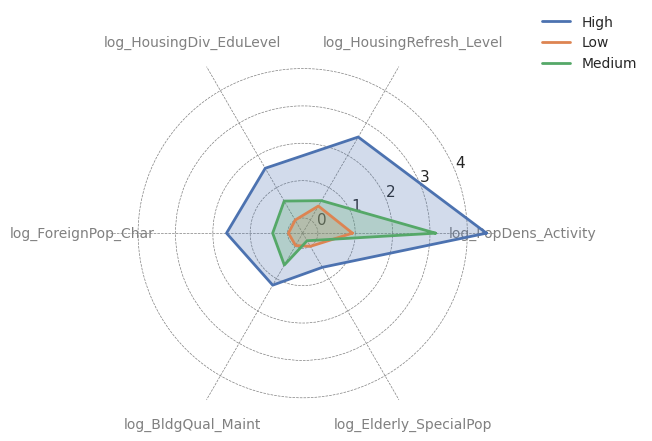

In [ ]:
cluster_means = gdf.groupby('Cluster_name')[['log_PopDens_Activity', 'log_HousingRefresh_Level',
                                        'log_HousingDiv_EduLevel', 'log_ForeignPop_Char',
                                        'log_BldgQual_Maint', 'log_Elderly_SpecialPop']].mean()

num_vars = len(cluster_means.columns)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))
fig.patch.set_facecolor('white')

for index, row in cluster_means.iterrows():
    data = row.tolist()
    data += data[:1]
    ax.plot(angles, data, label=str(index), linewidth=2)
    ax.fill(angles, data, alpha=0.25)

labels = cluster_means.columns
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

# plot's appearance
ax.spines['polar'].set_visible(False)
ax.grid(color='grey', linestyle='--', linewidth=0.5)
ax.xaxis.label.set_color('grey')
ax.yaxis.label.set_color('grey')

for label in ax.get_xticklabels():
    label.set_fontsize(10)
    label.set_color('grey')

ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1.1), fontsize=10)

plt.show()

Each cluster reflects different levels of neighbourhood quality.To make the subsequent study more convenient, the cluster with the highest percentage of radargrams is referred to as **High**,the rest as **Medium** and **Low**：

**High - "Rapidly Developing and Modernized Communities":**</br>
These communities score highest on all indicators, suggesting they are rapidly developing and highly modernized areas. They are characterized by high population density and vibrant community life, contemporary housing and construction, a variety of housing options alongside a high level of resident education, cultural diversity with a significant expatriate population, superior building quality with excellent maintenance, and a higher proportion of elderly and special focus groups.

**Medium - "Stably Developing and Balanced Communities":**</br>
With intermediate scores on all indicators, these communities are likely stable in development with a balanced residential life. They have moderate population size and density, a balanced mix of housing ages and conditions, diverse housing and reasonable education levels, a fair proportion of foreign residents and cultural diversity, good building quality and maintenance, and a moderate proportion of the elderly and special focus groups.

**Low - "Slowly Developing and Traditional Communities":**</br>
Scoring lowest on all indicators, these communities may be developing more slowly, retaining more traditional characteristics. They have lower population size and density, older housing and constructions, less diversity in housing types and education levels, fewer foreign residents indicating limited cultural diversity, relatively lower building quality and maintenance, and a smaller proportion of elderly and special focus groups.

## 3 CDR - hotspot (temporal & spatial)

### 3.1 Temporal pattern

Collating clustering results for backup

In [ ]:
cluster_neighbourhood = gdf.copy()
cluster_neighbourhood = cluster_neighbourhood[['cellId', 'Cluster_name', 'geometry']]
cluster_neighbourhood = cluster_neighbourhood.rename(columns={'cellId': 'grid_i'})
#cluster_neighbourhood.to_csv('/content/drive/MyDrive/NEU_LONDON/cluster_neighbourhood.csv', index=False)
cluster_neighbourhood.head(2)

,grid_i,Cluster_name,geometry
0,38,Low,"POLYGON ((649100.000 5060500.000, 650100.000 5..."
1,39,Low,"POLYGON ((650100.000 5060500.000, 651100.000 5..."


Read Trentino internal telecommunication flow and remove insignificant edges and nodes by setting edge weight threshold value as 75th percentile.

In [ ]:
column_names = ["time", "grid_i", "grid_j", "weight"]
telecommunication = pd.read_csv("/content/drive/MyDrive/NEU_LONDON/TNtoTN-2013-11-06.csv", sep="\t", header=None, names=column_names)

# Setting the threshold reduces the edge, set threshold as 75th percentile
weight_stats = telecommunication['weight'].describe()
threshold = weight_stats['75%']
telecommunication_25 = telecommunication[telecommunication['weight'] > threshold]
#telecommunication_25.to_csv('/content/drive/MyDrive/NEU_LONDON/telecommunication_25.csv', index=False)

Re-read the above two files

In [ ]:
# Read files
telecommunication_25 = pd.read_csv("/content/drive/MyDrive/NEU_LONDON/telecommunication_25.csv")
cluster_neighbourhood = pd.read_csv('/content/drive/MyDrive/NEU_LONDON/cluster_neighbourhood.csv')

- Manipulating telecommunication flow into hour scale
- Merging telecommunication and neighborhood characteristics (cluster result)

In [ ]:
# Removing internal flow from grid
telecommunication_25 = telecommunication_25.query("grid_i != grid_j")
# Extracting hour from timestamp
telecommunication_25['hour'] = pd.to_datetime(telecommunication_25['time'], unit='ms').dt.hour
# Aggregating to hour scale
telecommunication_hour = telecommunication_25.groupby(['hour', 'grid_i', 'grid_j'])['weight'].sum().reset_index()

In [ ]:
telecommunication_neighborhood = telecommunication_hour.merge(cluster_neighbourhood, on='grid_i', how='left')
telecommunication_neighborhood.head(2)

,hour,grid_i,grid_j,weight,Cluster_name,geometry
0,0,158,2264,0.000405,Low,"POLYGON ((652100.0000000121 5061499.999998645,..."
1,0,158,2265,0.000553,Low,"POLYGON ((652100.0000000121 5061499.999998645,..."


Defining weighted K-shell centrality function and applying to each hour to get hotspots (top 30)

In [ ]:
def calculate_hourly_dynamics(hour, telecommunication_neighborhood, cluster_neighbourhood):
    # Filter the data for each hour
    telecommunication_hour = telecommunication_neighborhood[telecommunication_neighborhood['hour'] == hour]
    G_hour = nx.from_pandas_edgelist(telecommunication_hour, source='grid_i', target='grid_j', edge_attr=['weight'])

    # Calculate Weighted K-shell centrality for each node
    weighted_k_shell = {}
    for node in G_hour.nodes():
        degree = G_hour.degree(node)
        weighted_sum = sum(weight for _, _, weight in G_hour.edges(node, data='weight'))
        weighted_k_shell[node] = np.sqrt(degree * weighted_sum)

    # Top 30 nodes
    top_30_nodes = sorted(weighted_k_shell, key=weighted_k_shell.get, reverse=True)[:30]
    top_30_df = pd.DataFrame({
        'grid_i': top_30_nodes,
        'weighted_k_shell': [weighted_k_shell[node] for node in top_30_nodes]
    })

    # Merging with cluster names
    top_30_with_cluster_name = top_30_df.merge(
        cluster_neighbourhood[['grid_i', 'Cluster_name']],
        on='grid_i',
        how='left'
    )

    # Calculating the count for each cluster
    high_count = top_30_with_cluster_name["Cluster_name"].value_counts().get('High', 0) / 42
    medium_count = top_30_with_cluster_name["Cluster_name"].value_counts().get('Medium', 0) / 300
    low_count = top_30_with_cluster_name["Cluster_name"].value_counts().get('Low', 0) / 4926

    return {'time': hour, 'High': high_count, 'Medium': medium_count, 'Low': low_count}

# Applying the function for each hour
day_dynamics = pd.DataFrame([calculate_hourly_dynamics(hour, telecommunication_neighborhood, cluster_neighbourhood) for hour in range(24)])
print(day_dynamics)

    time      High    Medium       Low
0      0  0.190476  0.010000  0.003857
1      1  0.238095  0.010000  0.003045
2      2  0.190476  0.013333  0.003451
3      3  0.119048  0.023333  0.003654
4      4  0.142857  0.013333  0.004060
5      5  0.261905  0.016667  0.002842
6      6  0.428571  0.010000  0.001827
7      7  0.357143  0.020000  0.001624
8      8  0.380952  0.023333  0.001421
9      9  0.380952  0.013333  0.001421
10    10  0.428571  0.020000  0.001218
11    11  0.404762  0.023333  0.001218
12    12  0.428571  0.020000  0.001015
13    13  0.380952  0.020000  0.001624
14    14  0.428571  0.020000  0.001218
15    15  0.452381  0.013333  0.001421
16    16  0.452381  0.016667  0.001015
17    17  0.452381  0.020000  0.001015
18    18  0.452381  0.020000  0.001015
19    19  0.428571  0.020000  0.001218
20    20  0.404762  0.023333  0.001218
21    21  0.380952  0.020000  0.001624
22    22  0.380952  0.020000  0.001624
23    23  0.238095  0.010000  0.003451


Visualisation

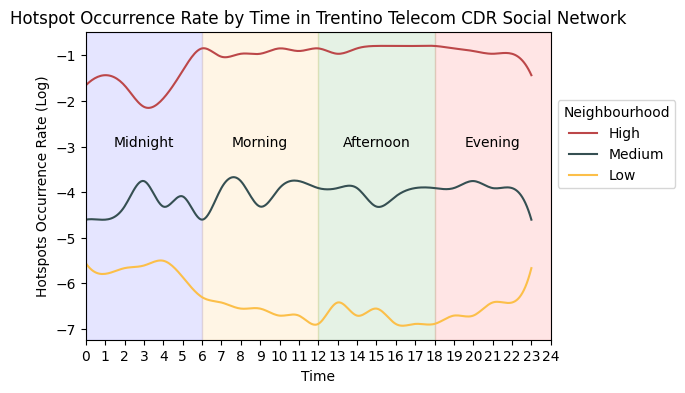

In [ ]:
from scipy.interpolate import interp1d

plt.figure(figsize=(6, 4))

log_high = np.log(day_dynamics['High'])
log_medium = np.log(day_dynamics['Medium'])
log_low = np.log(day_dynamics['Low'])
time = day_dynamics['time']

# Spline interpolation for smooth curves
spl_high = interp1d(time, log_high, kind='cubic')
spl_medium = interp1d(time, log_medium, kind='cubic')
spl_low = interp1d(time, log_low, kind='cubic')

time_smooth = np.linspace(min(time), max(time), 300)

plt.plot(time_smooth, spl_high(time_smooth), label='High', color='#bc4749')
plt.plot(time_smooth, spl_medium(time_smooth), label='Medium', color='#354f52')
plt.plot(time_smooth, spl_low(time_smooth), label='Low', color='#fcbf49')

# colored rectangles
plt.axvspan(0, 6, color='blue', alpha=0.1)
plt.text(3, -3, 'Midnight', horizontalalignment='center')

plt.axvspan(6, 12, color='orange', alpha=0.1)
plt.text(9, -3, 'Morning', horizontalalignment='center')

plt.axvspan(12, 18, color='green', alpha=0.1)
plt.text(15, -3, 'Afternoon', horizontalalignment='center')

# Extend the red rectangle to include the virtual '24' hour marker
plt.axvspan(18, 24, color='red', alpha=0.1)
plt.text(21, -3, 'Evening', horizontalalignment='center')

plt.title('Hotspot Occurrence Rate by Time in Trentino Telecom CDR Social Network')
plt.xlabel('Time')
plt.ylabel('Hotspots Occurrence Rate (Log)')
plt.xticks(range(0, 25))  # Extend the x-ticks to include '24'
plt.xlim(0, 24)  # Set the x-axis limit to include the virtual '24' hour marker
plt.legend(title = 'Neighbourhood',loc='upper left', bbox_to_anchor=(1, 0.8))

plt.savefig('/content/drive/MyDrive/NEU_LONDON/Trentino_hotspot_rate.png', dpi=300, format='png', bbox_inches='tight', transparent=True)
plt.show()


### 3.2 Spatial pattern

In [ ]:
def assign_period(hour):
    if 0 <= hour <= 5:
        return 'Midnight'
    elif 6 <= hour <= 11:
        return 'Morning'
    elif 12 <= hour <= 17:
        return 'Afternoon'
    else:
        return 'Night'

telecommunication_neighborhood['period'] = telecommunication_neighborhood['hour'].apply(assign_period)

In [ ]:
def calculate_period_dynamics_modified(period, telecommunication_neighborhood, cluster_neighbourhood):
    # Filter the data for each period
    telecommunication_period = telecommunication_neighborhood[telecommunication_neighborhood['period'] == period]
    G_period = nx.from_pandas_edgelist(telecommunication_period, source='grid_i', target='grid_j', edge_attr=['weight'])

    # Calculate Weighted K-shell centrality for each node
    weighted_k_shell = {}
    for node in G_period.nodes():
        degree = G_period.degree(node)
        weighted_sum = sum(weight for _, _, weight in G_period.edges(node, data='weight'))
        weighted_k_shell[node] = np.sqrt(degree * weighted_sum)

    # Top 30 nodes
    top_30_nodes = sorted(weighted_k_shell, key=weighted_k_shell.get, reverse=True)[:30]
    top_30_df = pd.DataFrame({
        'grid_i': top_30_nodes,
        'weighted_k_shell': [weighted_k_shell[node] for node in top_30_nodes]
    })

    # Merging with cluster names
    top_30_with_cluster_name = top_30_df.merge(
        cluster_neighbourhood[['grid_i', 'Cluster_name','geometry']],
        on='grid_i',
        how='left'
    )

    return top_30_with_cluster_name

# Calculating for each period and assigning to separate variables
top_30_with_cluster_name_midnight = calculate_period_dynamics_modified('Midnight', telecommunication_neighborhood, cluster_neighbourhood)
top_30_with_cluster_name_morning = calculate_period_dynamics_modified('Morning', telecommunication_neighborhood, cluster_neighbourhood)
top_30_with_cluster_name_afternoon = calculate_period_dynamics_modified('Afternoon', telecommunication_neighborhood, cluster_neighbourhood)
top_30_with_cluster_name_night = calculate_period_dynamics_modified('Night', telecommunication_neighborhood, cluster_neighbourhood)


Converting to geofile & calculating hotspot location (centroid of grid)

In [ ]:
import geopandas as gpd
from shapely import wkt

def convert_to_geodataframe(df):
    # shapely object
    df['geometry'] = df['geometry'].apply(wkt.loads)

    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    return gdf
def add_geometry_hotspot(gdf):
    gdf['geometry_hotspot'] = gdf['geometry'].centroid
    return gdf

top_30_with_cluster_name_midnight_gdf = convert_to_geodataframe(top_30_with_cluster_name_midnight)
top_30_with_cluster_name_midnight_gdf = add_geometry_hotspot(top_30_with_cluster_name_midnight_gdf)

top_30_with_cluster_name_morning_gdf = convert_to_geodataframe(top_30_with_cluster_name_morning)
top_30_with_cluster_name_morning_gdf = add_geometry_hotspot(top_30_with_cluster_name_morning_gdf)

top_30_with_cluster_name_afternoon_gdf = convert_to_geodataframe(top_30_with_cluster_name_afternoon)
top_30_with_cluster_name_afternoon_gdf = add_geometry_hotspot(top_30_with_cluster_name_afternoon_gdf)

top_30_with_cluster_name_night_gdf = convert_to_geodataframe(top_30_with_cluster_name_night)
top_30_with_cluster_name_night_gdf = add_geometry_hotspot(top_30_with_cluster_name_night_gdf)

Visualisation

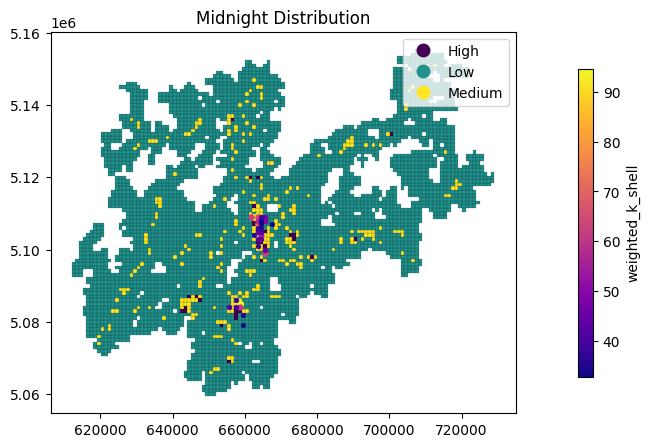

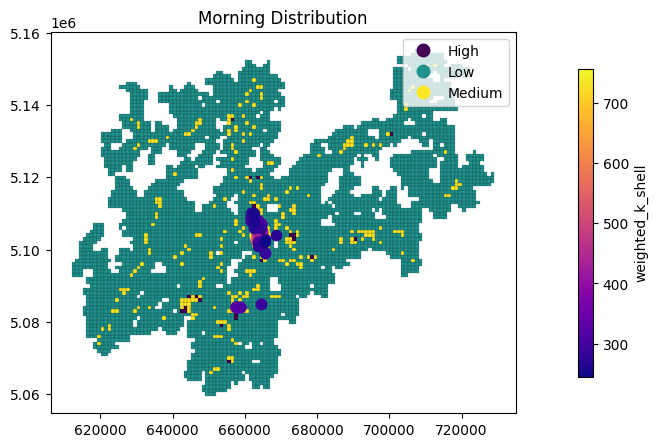

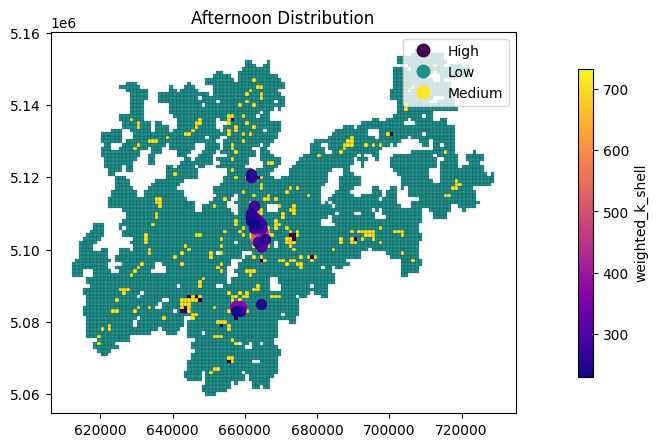

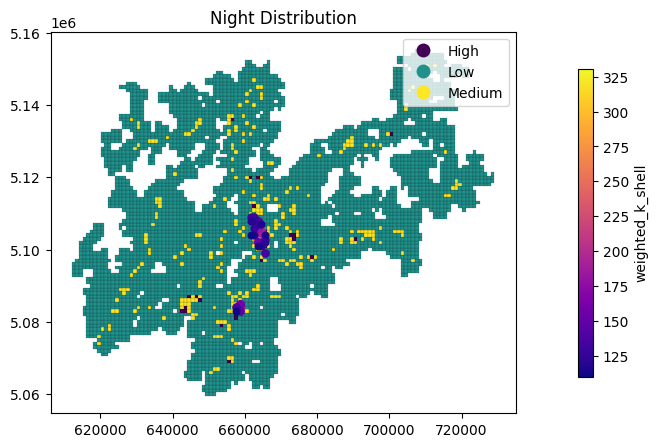

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely import wkt
import geopandas as gpd

def plot_distribution(data_gdf, title, save_path):
    # Merge and process the data
    distribution = cluster_neighbourhood.merge(data_gdf, on='grid_i', how='left')
    distribution = distribution.drop('geometry_y', axis=1)
    distribution = distribution.rename(columns={'geometry_x': 'geometry'})
    distribution['geometry'] = distribution['geometry'].apply(wkt.loads)
    distribution = gpd.GeoDataFrame(distribution, geometry='geometry')

    fig, ax = plt.subplots(figsize=(8, 8))
    distribution.plot(column='Cluster_name_x', categorical=True, legend=True, cmap='viridis',
                      edgecolor='black', linewidth=0.1, missing_kwds={'color': 'lightgrey'}, ax=ax)

    # Create a color map for the points
    cmap = plt.cm.plasma
    norm = mcolors.Normalize(vmin=data_gdf['weighted_k_shell'].min(),
                             vmax=data_gdf['weighted_k_shell'].max())

    # Plotting the points
    for idx, row in data_gdf.iterrows():
        ax.scatter(row['geometry_hotspot'].x, row['geometry_hotspot'].y, color=cmap(norm(row['weighted_k_shell'])),
                   s=row['weighted_k_shell']*0.2)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', label='weighted_k_shell', shrink=0.5, aspect=20, pad=0.1)
    cbar.set_label('weighted_k_shell', size=10)

    plt.title(title)

    plt.savefig(save_path, dpi=300, format='png', bbox_inches='tight', transparent=True)
    plt.show()

# Call the function for each dataset
plot_distribution(top_30_with_cluster_name_midnight_gdf, 'Midnight Distribution', '/content/drive/MyDrive/NEU_LONDON/midnight_distribution.png')
plot_distribution(top_30_with_cluster_name_morning_gdf, 'Morning Distribution', '/content/drive/MyDrive/NEU_LONDON/morning_distribution.png')
plot_distribution(top_30_with_cluster_name_afternoon_gdf, 'Afternoon Distribution', '/content/drive/MyDrive/NEU_LONDON/afternoon_distribution.png')
plot_distribution(top_30_with_cluster_name_night_gdf, 'Night Distribution', '/content/drive/MyDrive/NEU_LONDON/night_distribution.png')


## 4 EI Homophily Index

In [ ]:
cluster_neighbourhoo_backup = pd.DataFrame({
    'grid_j': cluster_neighbourhood['grid_i'],
    'Cluster_name_j': cluster_neighbourhood['Cluster_name']
})
index = telecommunication_neighborhood.rename(columns={'Cluster_name': 'Cluster_name_i'})
index = index.merge(cluster_neighbourhoo_backup, on='grid_j', how='left')

In [ ]:
def calculate_ei_for_periods(df, periods, categories):
    results = []

    for period in periods:
        period_df = df[df['period'] == period]

        for category in categories:
            internal = period_df[(period_df['Cluster_name_i'] == category) & (period_df['Cluster_name_j'] == category)].shape[0]
            external = period_df[(period_df['Cluster_name_i'] == category) | (period_df['Cluster_name_j'] == category)].shape[0] - internal
            ei_index = (external - internal) / (external + internal) if (external + internal) != 0 else 0
            results.append({'Period': period, 'Category': category, 'EI_Index': ei_index})

    return pd.DataFrame(results)

periods = ['Midnight', 'Morning', 'Night', 'Afternoon']
categories = ['High', 'Low', 'Medium']

ei_results = calculate_ei_for_periods(index, periods, categories)

print(ei_results)

       Period Category  EI_Index
0    Midnight     High  0.956071
1    Midnight      Low -0.271087
2    Midnight   Medium  0.898354
3     Morning     High  0.974749
4     Morning      Low -0.261661
5     Morning   Medium  0.909893
6       Night     High  0.967262
7       Night      Low -0.256214
8       Night   Medium  0.905053
9   Afternoon     High  0.974649
10  Afternoon      Low -0.259185
11  Afternoon   Medium  0.909051
